# Human Connectome Project: Task data + Behavioral data
The Human Connectome Project dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated version of this dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest. 

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

This Notebook provides code for downloading the data and doing some basic visualisation and processing.

The Notebook was created by Neuromatch Academy (original version available [here](https://github.com/NeuromatchAcademy/course-content)) and edited by Prof. Peter J. Kohler for use in NRSC-2200.

## Section 0: Setup

### Import necessary packages

In [1]:
import os, requests, tarfile
import numpy as np
import matplotlib.pyplot as plt

### Install the Nilearn package
We will use this for making plots of the whole brain surface.

In [2]:
!pip install nilearn --quiet
from nilearn import plotting, datasets

/Users/kohler/anaconda3/envs/MRI/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [65]:
# the download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions', the task or stimuli that were used.
# TIP: look inside the data folders for more fine-grained information about conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

### Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [29]:
fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download/"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
            fid.write(r.content)
        print(f"Download {fname} completed!")

In [30]:
if not os.path.isfile(os.path.join(HCP_DIR,'subjects_list.txt')):
    !tar -xzf $fname -C $HCP_DIR --strip-components=1
subjects = np.loadtxt(os.path.join(HCP_DIR,'subjects_list.txt'),dtype='str')

### Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



### Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [66]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

### define helper functions

We provide three helper functions: 

* **load_single_timeseries**: Loads the time series from a single suject and a single run

* **load_evs**: Loads an EV file for each task. An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

* **average_frames**: Averages all frames (TRs) from any given condition


In [31]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment 
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

    Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

    Returns
    evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    for cond in EXPERIMENTS[experiment]['cond']:    
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)

    return frames_list

def average_frames(data, evs, experiment, cond):
    # get the index for the requested condition
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)

## Section 1: Plot time series of example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run.

In [67]:
my_exp  = 'MOTOR' 
my_subj = subjects[1]
my_run  = 1

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
print(data.shape)

(360, 284)


As you can see the time series data contains 284 time points in 360 regions of interest (ROIs).

Let's plot the time series within a single, randomly chosen, brain region. To do this, we also need to create a variable that describes the timing of each acquisition (TR) during the run. 

In [68]:
time_points = [x*TR for x in list(range(data.shape[1]))]
roi_to_plot = data[0]
if len(time_points) == len(roi_to_plot):
    print( "roi data and time points have same length: {}".format(len(time_points)) )

roi data and time points have same length: 284


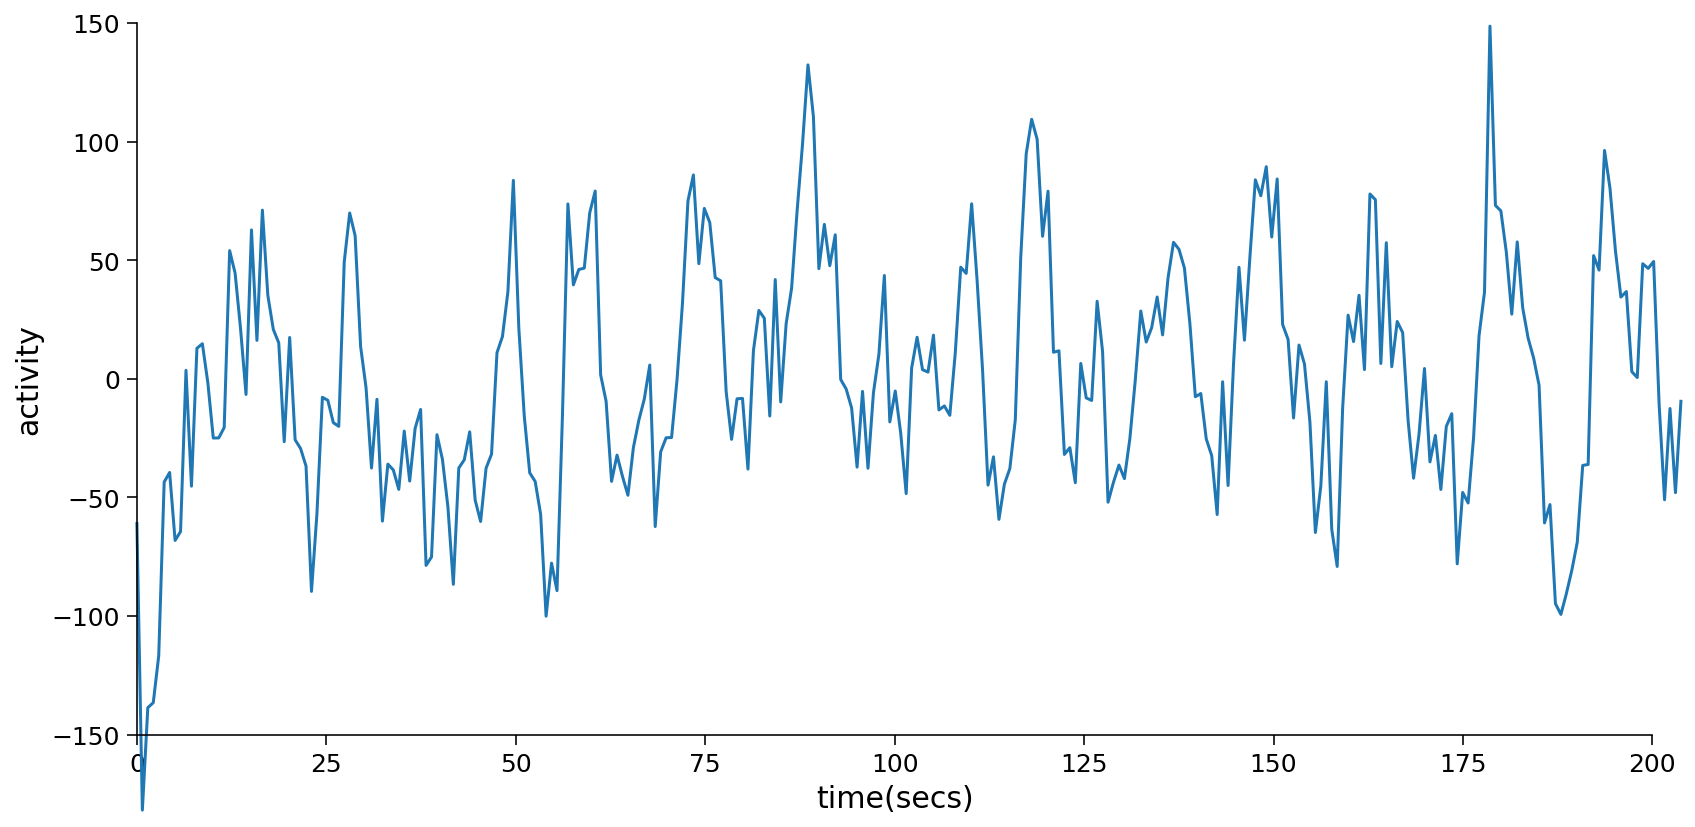

In [69]:
time_fig = plt.figure(figsize=[12,6]) # save figure handle, given interpretable name
plt.plot(time_points, roi_to_plot, clip_on=False)
plt.xlim([0,200])
plt.ylim([-150,150])
plt.xlabel("time(secs)")
plt.ylabel('activity')
plt.show()

## Section 2: Investigate the tasks parameters

Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [71]:
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)
print("number of conditions in evs is {}".format(len(evs)))

number of conditions in evs is 6


For the motor task, this evs variable contains a list of 6 arrays corresponding to the 6 conditions. We can query the EXPERIMENTS dataframe we created above, to figure out what the conditions were. 

In [36]:
cond_list = EXPERIMENTS[my_exp]["cond"]
print(cond_list)

['lf', 'rf', 'lh', 'rh', 't', 'cue']


Great! the number of conditions in evs corresponds to the number of conditions in cond_list. Each element of **evs** is itself a list, with each element in the list being a list of the TRs where that particular condition occurred.

In [73]:
print( "the first presentation of condition '{}' occurred at TRs:\n {}".format(cond_list[0], evs[0][0]) )
print( "the second presentation of condition '{}' occurred at TRs:\n {}".format(cond_list[0], evs[0][1]) )

the first presentation of condition 'lf' occurred at TRs:
 [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115]
the second presentation of condition 'lf' occurred at TRs:
 [246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262]


We can make that more manageable by converting to an array and the using the flatten function to make it a one-dimensional array. We use list comprehension to make a new list, **cond_times**, that has every TR during which a condition occured, for each condition. We can also make a list that counts the number of TRs:

In [74]:
cond_times = [ np.array(e).flatten() for e in evs ]
tr_count = [len(c) for c in cond_times]
print("here are the number of TRs that each condition occupied during this run:\n{}".format(tr_count) )

here are the number of TRs that each condition occupied during this run:
[34, 34, 34, 34, 34, 50]


Note that the final condition occured more often.

Now we can add our event timing to the figure from before. Note that we use the named input variable **"label"** with the call to plt.plot. That assign a label to each dataseries in the plot (in this case, the events that occurred during the run) and let's use put a nice legend on the figure by simply calling plt.legend without inputs. 

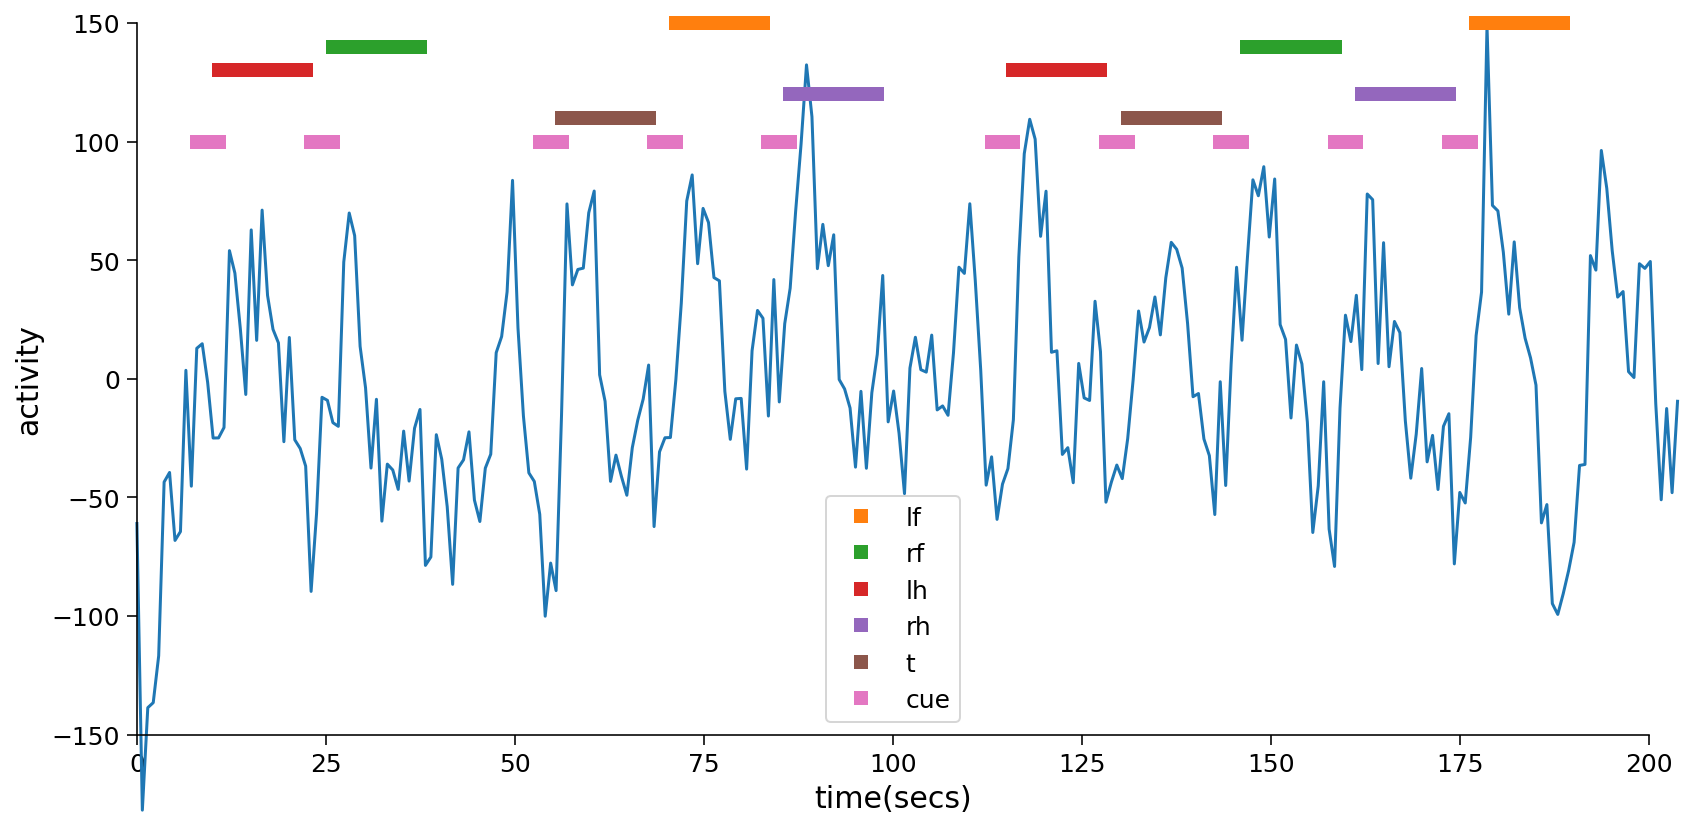

In [75]:
plt.figure(time_fig) # grab figure handle defined earlier
for i, e in enumerate(cond_times):
    plt.plot(e*TR, np.ones_like(e)*(150-i*10), 's', clip_on=False, label=cond_list[i])
plt.legend()
plt.show()

We see that our conditions are non-overlapping, except for cue, which makes sense giving that cue was likely what told participants to switch to a different motor behavior. 

## Section 3: Plot averaged data from different regions-of-interest (ROIs)

This is cool, but difficult to interpret. Let's try to average the activity across timepoints for a specific condition. 

We will compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [42]:
lf_activity = average_frames(data, evs, my_exp, 'lf')
rf_activity = average_frames(data, evs, my_exp, 'rf')
contrast    = lf_activity-rf_activity   # difference between left and right hand movement

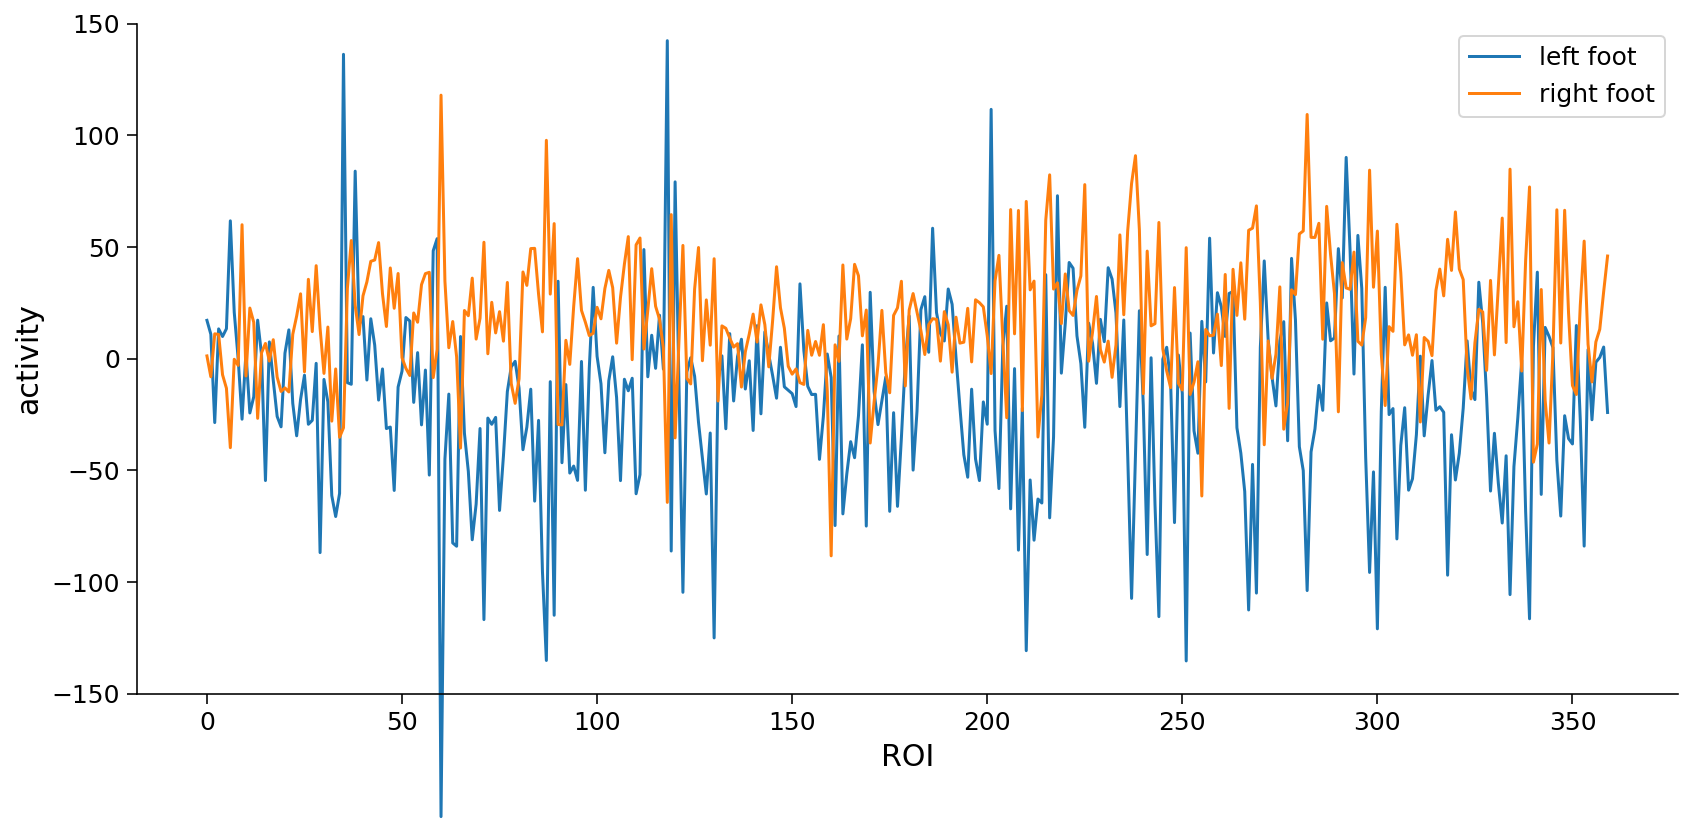

In [43]:
# Plot activity level in each ROI for both conditions
roi_fig = plt.figure(figsize=[12,6])
plt.plot(lf_activity,label='left foot', clip_on=False)
plt.plot(rf_activity,label='right foot', clip_on=False)
plt.xlabel('ROI')
plt.ylabel('activity')
plt.ylim([-150,150])
plt.legend()
plt.show()

## Section 4: Plot averaged data from different networks of ROIs

This is still quite messy. We would want to make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network. We will plot the activity averaged over each network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn to visualise it.

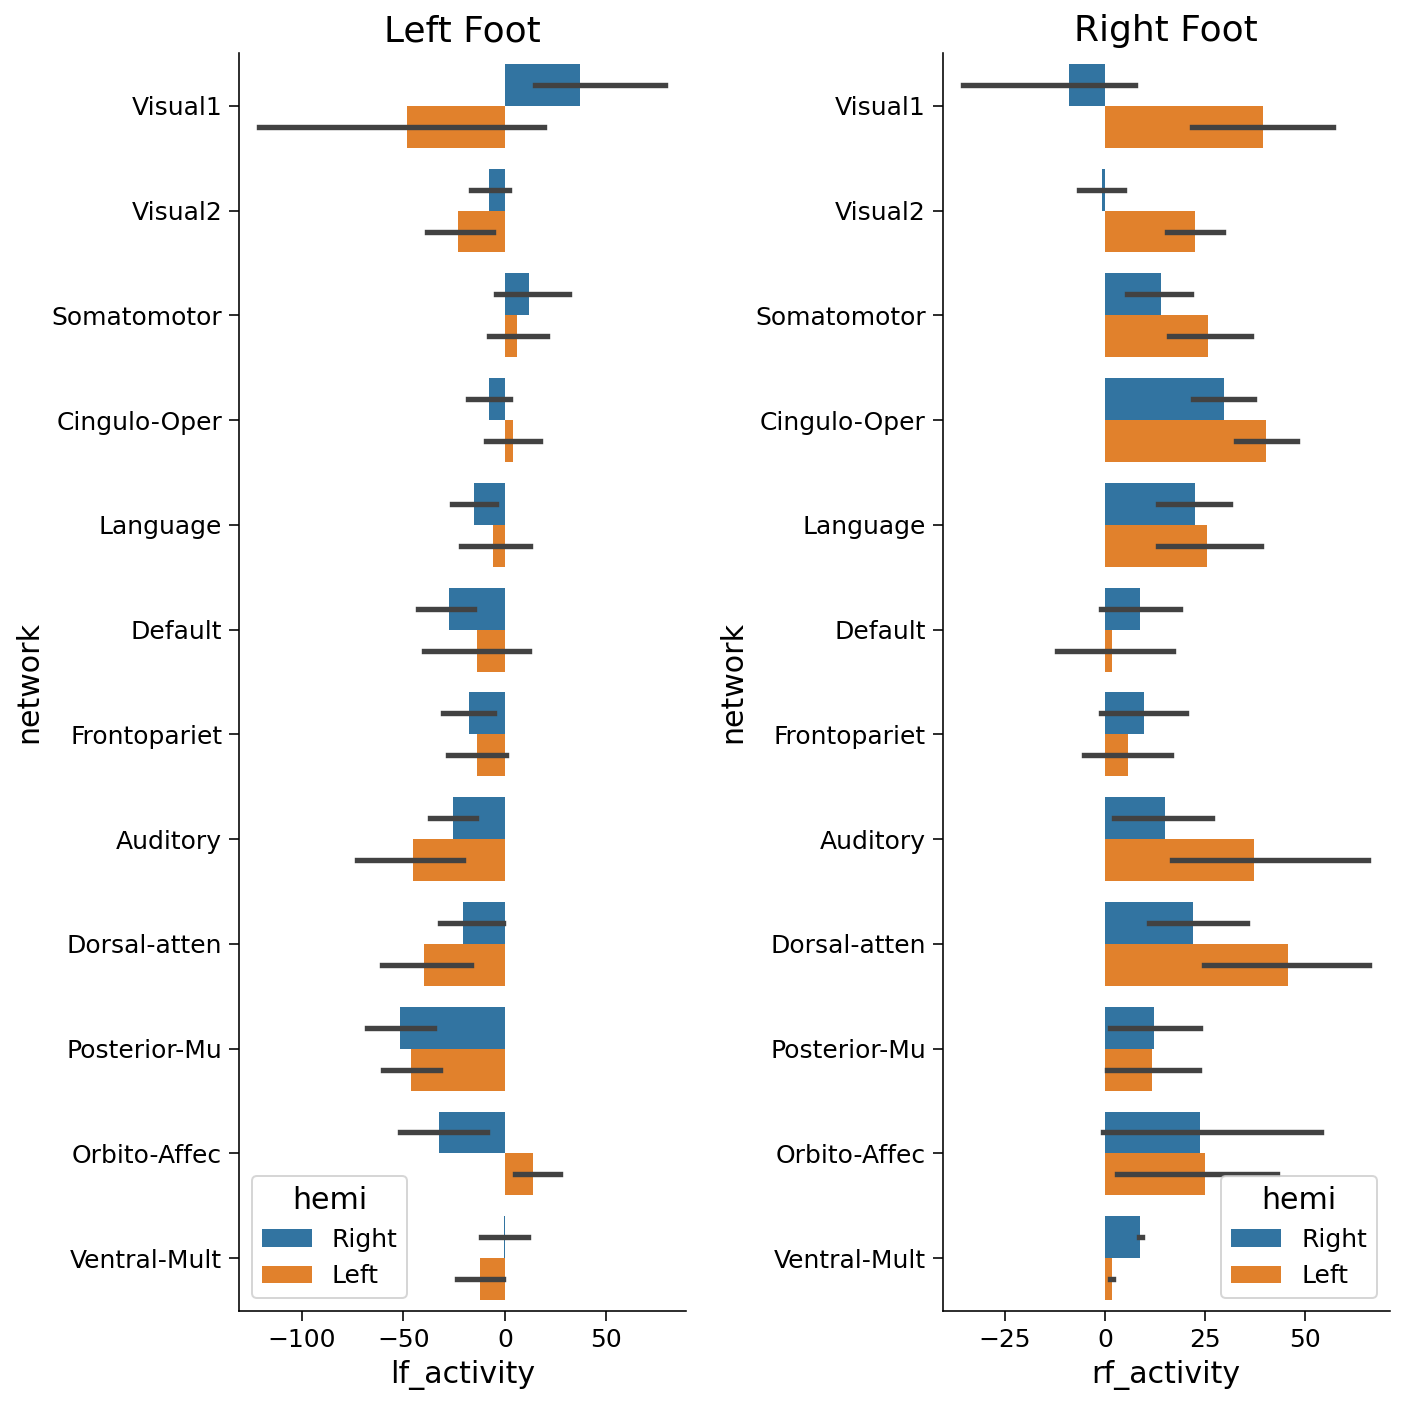

In [45]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'lf_activity' : lf_activity,
                   'rf_activity' : rf_activity,
                   'network'     : region_info['network'],
                   'hemi'        : region_info['hemi']})

network_fig,(ax1,ax2) = plt.subplots(1,2, figsize=[10,10])
sns.barplot(y='network', x='lf_activity', data=df, hue='hemi',ax=ax1)
ax1.title.set_text("Left Foot")
sns.barplot(y='network', x='rf_activity', data=df, hue='hemi',ax=ax2)
ax2.title.set_text("Right Foot")
plt.show()

You should be able to notice that for the somatosensory network, brain activity in the right hemisphere is higher for the left foot movement and vice versa for the left hemisphere and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans). 

## Section 5: Compute group-level contrasts

Let us boost these stats by averaging across all subjects and runs. 

In [22]:
group_contrast = 0
for s in subjects:
    for r in [0,1]:
        data = load_single_timeseries(subject=s, experiment=my_exp, run=r, remove_mean=True)
        evs = load_evs(subject=s, experiment=my_exp, run=r)

        lf_activity = average_frames(data, evs, my_exp, 'lf')
        rf_activity = average_frames(data, evs, my_exp, 'rf')

        contrast    = lf_activity-rf_activity
        group_contrast        += contrast # the same as group_contrast = group_contrast + contrast

group_contrast = group_contrast / (len(subjects)*2)  # remember: 2 sessions per subject

note that we are computing a contrast: the difference between the two conditions

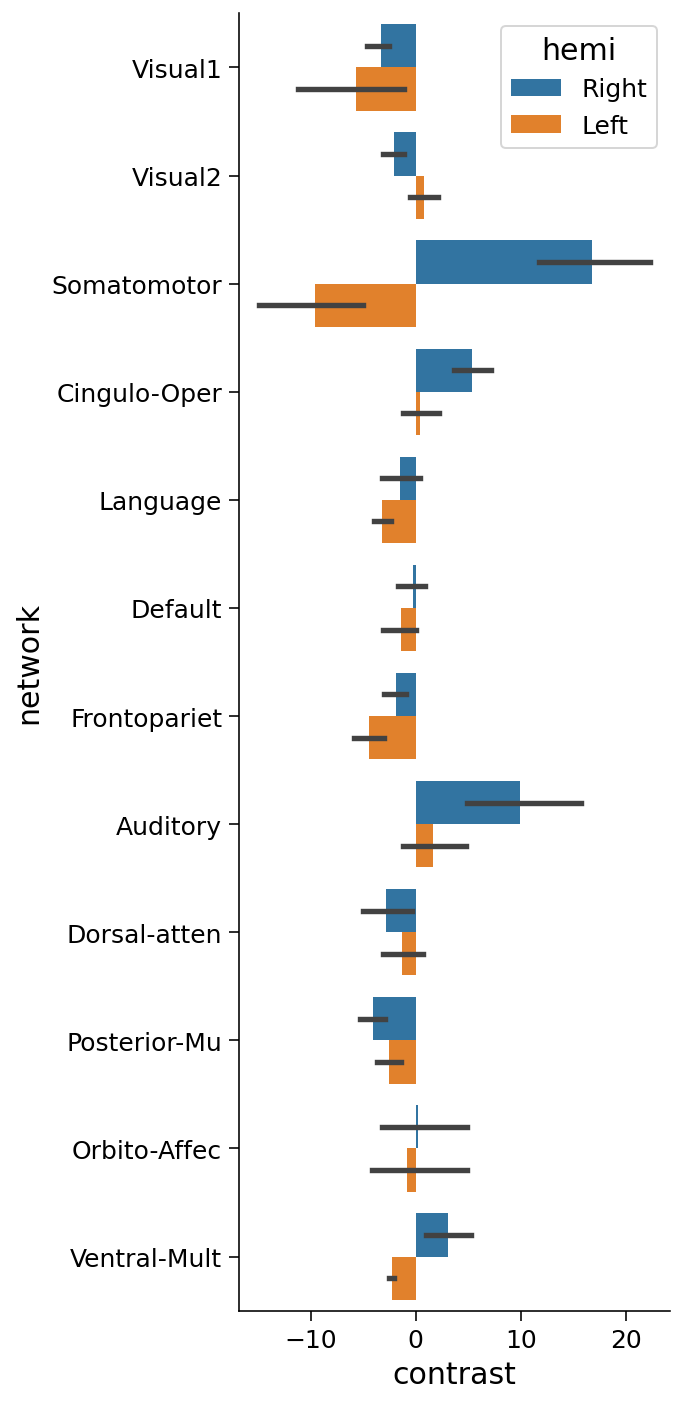

In [28]:
df = pd.DataFrame({'contrast':group_contrast,'network':region_info['network'],'hemi':region_info['hemi']})
# we will plot the left foot minus right foot contrast so we only need one plot
fig = plt.figure(figsize=[5,10])
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

## Section 6: Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of a template brain. fsaverage is a template brain based on a combination of 40 MRI scans of real brains.

In [24]:
# load atlas containing the regions corresponding to the fMRI timeseries in the dataset 
url = "https://osf.io/j5kuc/download"
fname = "{}/hcp_atlas.npz".format(HCP_DIR)

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
            fid.write(r.content)
        print(f"Download {fname} completed!")
with np.load("{}/hcp_atlas.npz".format(HCP_DIR)) as dobj:
    atlas = dict(**dobj)

# load the fsaverage surface
fsaverage = datasets.fetch_surf_fsaverage()

Let's first plot all of the regions-of-interest on a flattened hemisphere. 

It is important to understand that the variables atlas["labels_L"] and atlas["labels_R"] contains the ROI indices for each vertex on the surface (10K+ vertices per hemisphere). Simply plotting them onto the surface will show us the location of each ROI. 

Note that we add one to our values to map to make our ROIs take on values between 1 and 360, and that we set our range (vmin and vmax) between 181 and 360, because those are the values assigned to **left** hemisphere ROIs. If we were plotting right hemisphere ROIs, we would set the range between 1 and 180.

In [60]:
# plot all regions of interest on the surface
roi_cmap = sns.color_palette("Spectral", as_cmap=True)
values_to_map = atlas["labels_L"]+1
plotting.view_surf(fsaverage['infl_left'], values_to_map, vmin=181, vmax=360, symmetric_cmap=False, cmap=roi_cmap)

Which of these regions are actually part of the somatomotor network we plotted in the bar graphs above? Let's define an variable somasens_lcl, identifying those regions, and simply assign one to every index that is part of the network, and zero to anywhere else. somasens_lcl is an array of  

We can now use atlas["labels_L"] as a numerical index into somasens_lcl, which means that the nth value of somasens_lcl is assigned to every vertex on the left hemisphere that has value n (indicating the region). The result is that every ROI that is a member of the somatomotor network get assigned value 1, and every other vertex gets assigned value zero.

In [64]:
# define index identifying somatosensory regions
somasens_idx = [idx for idx, name in enumerate(region_info["network"]) if "Somatomotor" in name]
somasens_lcl = np.zeros_like(group_contrast)
somasens_lcl[somasens_idx] = 1
# plot somatosensory regions of interest on the surface
values_to_map = somasens_lcl[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'], values_to_map, vmin=0, vmax=1, symmetric_cmap=False, cmap=roi_cmap)

/Users/kohler/anaconda3/envs/MRI/lib/python3.7/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/Users/kohler/anaconda3/envs/MRI/lib/python3.7/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning: vmin cannot be chosen when cmap is symmetric
  warnings.warn('vmin cannot be chosen when cmap is symmetric')


We can use the same somewhat tricky indexing principle to plot the values of the group contrast defined above on the cortical surface. Here the result is that the 360 distinct values for the group contrast (one per ROI across the whole brain) get asssigned to the ROI that has that index value. Note that you can plot right hemisphere data by simply replacing "labels_L" with "labels_R" and "infl_left" with "infl_right".

In [63]:
# plot group contrast on surface
activity_cmap = sns.color_palette("vlag", as_cmap=True) # define a color map
surf_contrast = group_contrast[atlas["labels_L"]]       # indexing the contrast values with the ROI indices
plotting.view_surf(fsaverage['infl_left'], surf_contrast, vmax=20, cmap=activity_cmap) #vmax = 20 seems good

/Users/kohler/anaconda3/envs/MRI/lib/python3.7/site-packages/nilearn/plotting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))
